In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
No GPU was detected. CNNs can be very slow without a GPU.


In [3]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()



In [7]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)
max_id = len(tokenizer.word_index)
dataset_size = tokenizer.document_count
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
# encoded = np.array(tokenizer.texts_to_sequences(shakespeare_text)) - 1
# encoded = encoded.reshape(-1)

In [183]:
n_steps = 256

def get_ds(src_data, batch_size = 32):
    window_length = n_steps + 1
    dataset_size = tokenizer.document_count
    result_ds = tf.data.Dataset.from_tensor_slices(src_data)

    result_ds = result_ds.window(window_length, shift=256, stride=1, drop_remainder=True)
    result_ds = result_ds.flat_map(lambda window: window.batch(window_length))
    result_ds = result_ds.shuffle(1000).batch(batch_size)
    result_ds = result_ds.map(lambda windows: (windows[:, :-1], windows[:, 1:])).repeat(10)
    result_ds = result_ds.prefetch(3)
    
    return result_ds

train_size = dataset_size * 90 // 100
valid_size = dataset_size * 95 // 100
train_ds = get_ds(encoded[:train_size])
valid_ds = get_ds(encoded[train_size:valid_size])


In [231]:
for batch_X,batch_Y in dataset.take(5):
#     print("batch:", idx)
    for idx, X, Y in zip(range(100), batch_X, batch_Y):
        print("item", idx, ":" , X.numpy(), "/", Y.numpy())
    print()

item 0 : [ 1 12  0  4  9 15  0 19 13] / [12  0  4  9 15  0 19 13  8]
item 1 : [20  4  5  9  0  2  3  0  2] / [4 5 9 0 2 3 0 2 6]
item 2 : [ 1  9  5 13  7 23 10  7  5] / [ 9  5 13  7 23 10  7  5  8]

item 0 : [ 7 13  8 22 11 13  7 17  0] / [13  8 22 11 13  7 17  0  2]
item 1 : [10 10 19  5  8  7  2  0 18] / [10 19  5  8  7  2  0 18  5]
item 2 : [12  7  2  0  3 27  0  2  6] / [ 7  2  0  3 27  0  2  6  1]

item 0 : [ 2  5 35  1  9 23 10 16  1] / [ 5 35  1  9 23 10 16  1 11]
item 1 : [ 8 14  0  3 13  8  0  7  3] / [14  0  3 13  8  0  7  3 11]
item 2 : [ 4  0  2  5 14  1  0 16  6] / [ 0  2  5 14  1  0 16  6  1]

item 0 : [ 3 21 32  1 18  2  0  3 19] / [21 32  1 18  2  0  3 19  0]
item 1 : [ 7 16  1  8  0 14  4 12  1] / [16  1  8  0 14  4 12  1  0]
item 2 : [15 17  0  2  6 13  7  0  4] / [17  0  2  6 13  7  0  4 18]

item 0 : [7 0 3 9 1 0 6 3 9] / [0 3 9 1 0 6 3 9 1]
item 1 : [ 8  1  0 16  1  0 21  1 18] / [ 1  0 16  1  0 21  1 18  3]
item 2 : [ 0 11  3  3 24  0 15  3 13] / [11  3  3 24  0 1

In [125]:
embeddings_dims = 5
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim = max_id, output_dim = embeddings_dims, input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.GRU(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    keras.layers.GRU(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    keras.layers.Dense(max_id, activation="softmax"),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 5)           195       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          352       
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 32)          128       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          4160      
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 64)          256       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 96)          12384     
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 96)         

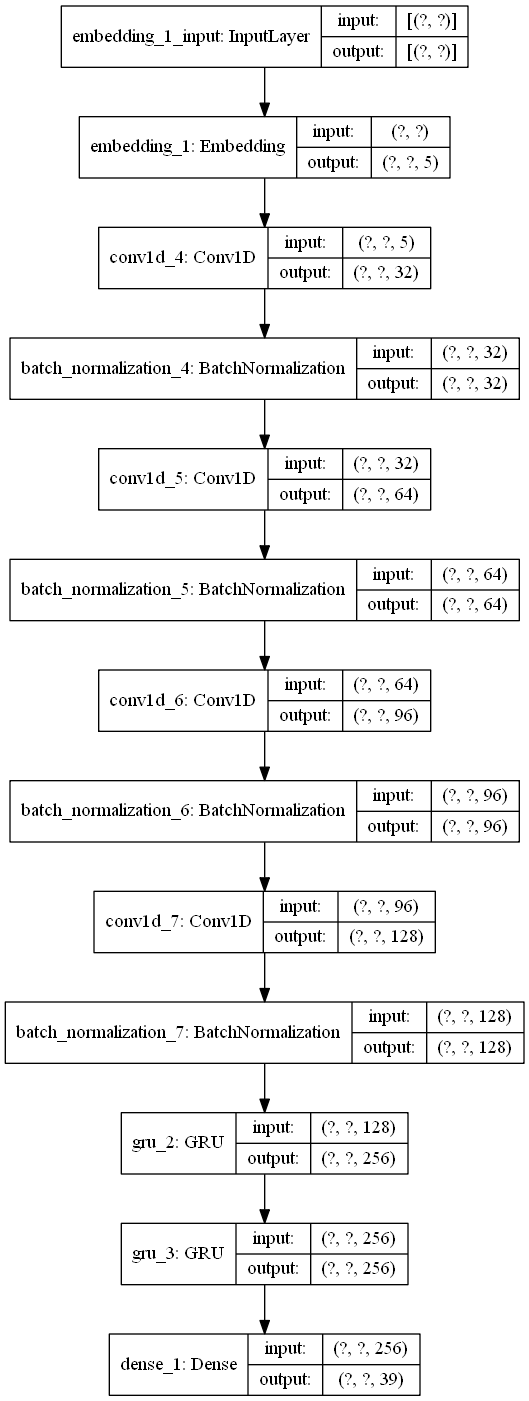

In [126]:
keras.utils.plot_model(model, show_shapes=True)


In [13]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics=["accuracy"])
history = model.fit(train_ds, epochs=20, validation_data=valid_ds)

Epoch 1/20
123/123 [==============================] - 185s 2s/step - loss: 2.6920 - accuracy: 0.2472 - val_loss: 3.5999 - val_accuracy: 0.0640
Epoch 2/20
123/123 [==============================] - 200s 2s/step - loss: 2.1211 - accuracy: 0.3834 - val_loss: 3.7188 - val_accuracy: 0.1060
Epoch 3/20
123/123 [==============================] - 200s 2s/step - loss: 1.9611 - accuracy: 0.4208 - val_loss: 3.5346 - val_accuracy: 0.1152
Epoch 4/20
123/123 [==============================] - 214s 2s/step - loss: 1.8637 - accuracy: 0.4453 - val_loss: 3.0228 - val_accuracy: 0.1673
Epoch 5/20
123/123 [==============================] - 206s 2s/step - loss: 1.7989 - accuracy: 0.4618 - val_loss: 2.2533 - val_accuracy: 0.3213
Epoch 6/20
123/123 [==============================] - 207s 2s/step - loss: 1.7523 - accuracy: 0.4731 - val_loss: 1.8158 - val_accuracy: 0.4518
Epoch 7/20
123/123 [==============================] - 206s 2s/step - loss: 1.7186 - accuracy: 0.4816 - val_loss: 1.7314 - val_accuracy: 0.4774

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


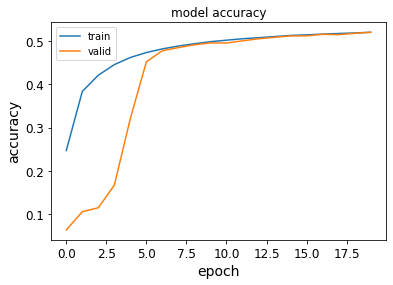

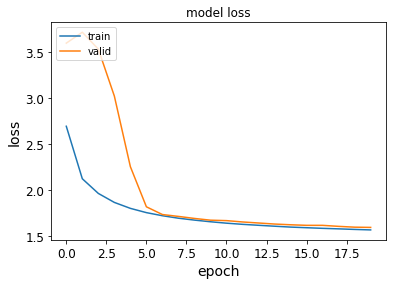

In [21]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [22]:
model.save("shakespeare.h5")

In [128]:
model = keras.models.load_model("shakespeare.h5")

In [131]:
model.evaluate(valid_ds)

      7/Unknown - 2s 227ms/step - loss: 1.5910 - accuracy: 0.5199

[1.5910364900316512, 0.51994526]

In [48]:
def preprocess(texts):
    [temp] = np.array(tokenizer.texts_to_sequences([texts])) - 1
    return temp

Y_pred = model.predict_classes(preprocess("Hello how are yo"))
tokenizer.sequences_to_texts(Y_pred+1)

['e',
 ' ',
 'e',
 'e',
 'u',
 't',
 'e',
 'u',
 'a',
 't',
 'r',
 'e',
 ' ',
 't',
 ' ',
 'u']

In [129]:
def next_char(texts, temperature=1):
    X_new = preprocess(texts)
    Y_proba = model.predict(X_new)[-1:, 0, :]
    rescaled_logits = tf.math.log(Y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples = 1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]
    
def complete_text(texts, n_chars = 50, temperature = 1):
    for idx in range(n_chars):
        texts += next_char(texts, temperature)
        
    return texts

complete_text("Hello how are yo", temperature=1)

"Hello how are younour kes; rble in sourorid te be.\nourites ipok'th"

---------- Statefull

In [184]:
stateful_batch_size = 1
stateful_train_ds = get_ds(encoded[:train_size], batch_size=stateful_batch_size)
stateful_valid_ds = get_ds(encoded[train_size:valid_size], batch_size=stateful_batch_size)


In [185]:
embeddings_dims = 5
stateful_model = keras.models.Sequential([
    keras.layers.Embedding(input_dim = max_id, output_dim = embeddings_dims, input_shape=[None], batch_input_shape=[stateful_batch_size, None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.GRU(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, stateful=True),
    keras.layers.GRU(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, stateful=True),
    keras.layers.Dense(max_id, activation="softmax"),
])
stateful_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (1, None, 5)              195       
_________________________________________________________________
conv1d_68 (Conv1D)           (1, None, 32)             352       
_________________________________________________________________
batch_normalization_68 (Batc (1, None, 32)             128       
_________________________________________________________________
conv1d_69 (Conv1D)           (1, None, 64)             4160      
_________________________________________________________________
batch_normalization_69 (Batc (1, None, 64)             256       
_________________________________________________________________
conv1d_70 (Conv1D)           (1, None, 96)             12384     
_________________________________________________________________
batch_normalization_70 (Batc (1, None, 96)           

In [188]:
class ReseStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [189]:
stateful_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
steps_per_epoch = train_size // (stateful_batch_size * n_steps)
stateful_history = stateful_model.fit(stateful_train_ds, epochs=10, steps_per_epoch=steps_per_epoch, validation_data=stateful_valid_ds, callbacks=[ReseStatesCallback()])

Train for 3921 steps
Epoch 1/10
3921/3921 [==============================] - 15750s 4s/step - loss: 1.9299 - accuracy: 0.4280 - val_loss: 1.6945 - val_accuracy: 0.4907
Epoch 2/10
3921/3921 [==============================] - 10489s 3s/step - loss: 1.6489 - accuracy: 0.4988 - val_loss: 1.6191 - val_accuracy: 0.5089
Epoch 3/10
3921/3921 [==============================] - 9814s 3s/step - loss: 1.5982 - accuracy: 0.5112 - val_loss: 1.5861 - val_accuracy: 0.5187
Epoch 4/10
3921/3921 [==============================] - 9351s 2s/step - loss: 1.5757 - accuracy: 0.5168 - val_loss: 1.5764 - val_accuracy: 0.5262
Epoch 5/10
3921/3921 [==============================] - 9244s 2s/step - loss: 1.5646 - accuracy: 0.5193 - val_loss: 1.5712 - val_accuracy: 0.5260
Epoch 6/10
3921/3921 [==============================] - 9975s 3s/step - loss: 1.5570 - accuracy: 0.5217 - val_loss: 1.5677 - val_accuracy: 0.5240
Epoch 7/10
3921/3921 [==============================] - 10360s 3s/step - loss: 1.5529 - accuracy: 0.5

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


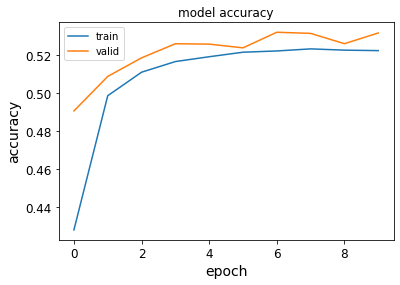

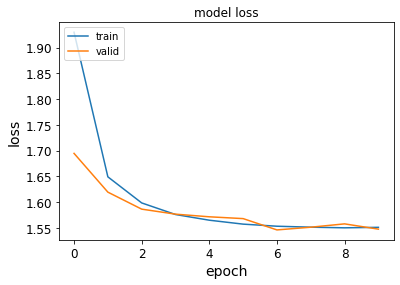

In [202]:
# list all data in history
print(stateful_history.history.keys())
# summarize history for accuracy
plt.plot(stateful_history.history['accuracy'])
plt.plot(stateful_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(stateful_history.history['loss'])
plt.plot(stateful_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [1]:
# stateful_model.save("shakespeare_stateful.h5")

In [193]:
stateful_model.evaluate(stateful_train_ds)

  39210/Unknown - 18785s 479ms/step - loss: 1.4472 - accuracy: 0.5508

[1.4471567324535848, 0.5508069]

In [194]:
embeddings_dims = 5
stateless_model = keras.models.Sequential([
    keras.layers.Embedding(input_dim = max_id, output_dim = embeddings_dims, input_shape=[None], batch_input_shape=[stateful_batch_size, None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.GRU(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    keras.layers.GRU(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    keras.layers.Dense(max_id, activation="softmax"),
])
stateless_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (1, None, 5)              195       
_________________________________________________________________
conv1d_72 (Conv1D)           (1, None, 32)             352       
_________________________________________________________________
batch_normalization_72 (Batc (1, None, 32)             128       
_________________________________________________________________
conv1d_73 (Conv1D)           (1, None, 64)             4160      
_________________________________________________________________
batch_normalization_73 (Batc (1, None, 64)             256       
_________________________________________________________________
conv1d_74 (Conv1D)           (1, None, 96)             12384     
_________________________________________________________________
batch_normalization_74 (Batc (1, None, 96)           

In [196]:
stateless_model.set_weights(stateful_model.get_weights())

In [210]:
def next_char(texts, temperature=1):
    X_new = preprocess(texts)
    Y_proba = stateless_model.predict(X_new)[-1:, 0, :]
    rescaled_logits = tf.math.log(Y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples = 1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]
    
def complete_text(texts, n_chars = 50, temperature = 1):
    for idx in range(n_chars):
        texts += next_char(texts, temperature)
        
    return texts

predicted_text = complete_text("Hello how are yo", temperature=2)

print(predicted_text)

Hello how are yod!
ivae
v
t'?
gih', r3que.
ow&cy k
hash:
blibs cha


------------ Sentiment analysis

In [2]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples

In [3]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

preprocess(
    [b'Hello how are you ?', b'My Name @$%%%asya'], 
    ([1,2])
)



(<tf.Tensor: shape=(2, 4), dtype=string, numpy=
 array([[b'Hello', b'how', b'are', b'you'],
        [b'My', b'Name', b'asya', b'<pad>']], dtype=object)>,
 [1, 2])

In [4]:
from collections import Counter 

vocab = Counter()

for __X, __y in datasets["train"].batch(32).map(preprocess):
    for review in __X:
#         print(list(review.numpy()))
        vocab.update(list(review.numpy()))

In [5]:
vocab.most_common()[:23]

[(b'<pad>', 214741),
 (b'the', 61137),
 (b'a', 38564),
 (b'of', 33983),
 (b'and', 33431),
 (b'to', 27707),
 (b'I', 27019),
 (b'is', 25719),
 (b'in', 18966),
 (b'this', 18490),
 (b'it', 17690),
 (b'was', 14950),
 (b'movie', 14945),
 (b'that', 14752),
 (b'The', 11879),
 (b'film', 10668),
 (b'with', 9073),
 (b'for', 8660),
 (b'as', 8578),
 (b'on', 7817),
 (b'but', 7724),
 (b'have', 7031),
 (b'This', 6672)]

In [6]:
len(vocab)

53893

In [7]:
vocab.get(b"and")

33431

In [8]:
vocab_size = 10000
truncated_vocab = [
    word for word, count in vocab.most_common()[:vocab_size]
]

In [9]:
words = tf.constant(truncated_vocab)
words_ids = tf.range(len(truncated_vocab), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, words_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [10]:
table.lookup((tf.strings.split([b"this movie was suuper"])).to_tensor())

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[    9,    12,    11, 10258]], dtype=int64)>

In [11]:
def encode_words(X_train, y_train):
    return table.lookup(X_train), y_train

batch_size = 32
train_set = datasets["train"].batch(batch_size).map(preprocess).map(encode_words)
test_set = datasets["test"].batch(batch_size).map(preprocess).map(encode_words)

for __X, __y in train_set.take(2):
    print(__X, __y)

tf.Tensor(
[[   22     7     2 ...     0     0     0]
 [ 1239    82     6 ...   418    28  4245]
 [ 4246     3     1 ...     0     0     0]
 ...
 [   22     7    23 ...     0     0     0]
 [ 1297  3744     7 ...     0     0     0]
 [10928 10687  4537 ...     0     0     0]], shape=(32, 60), dtype=int64) tf.Tensor([0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1], shape=(32,), dtype=int64)
tf.Tensor(
[[    6    65  9944 ...     0     0     0]
 [   74   154    12 ...     0     0     0]
 [  122   915     4 ...     0     0     0]
 ...
 [10794   158    52 ...     0     0     0]
 [   22     7     1 ...     4     6    21]
 [  295    27    94 ...     0     0     0]], shape=(32, 62), dtype=int64) tf.Tensor([1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1], shape=(32,), dtype=int64)


In [70]:
embed_size = 128
embedding_layer = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, input_shape=[None])
model = keras.models.Sequential([
#     keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, batch_input_shape=[batch_size, None]),
    embedding_layer,
    keras.layers.GRU(8, dropout=0.5, recurrent_dropout=0.5, return_sequences=True),
    keras.layers.GRU(8, dropout=0.5, recurrent_dropout=0.5),
    keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 128)         1408000   
_________________________________________________________________
gru_16 (GRU)                 (None, None, 8)           3312      
_________________________________________________________________
gru_17 (GRU)                 (None, 8)                 432       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 1,411,753
Trainable params: 1,411,753
Non-trainable params: 0
_________________________________________________________________


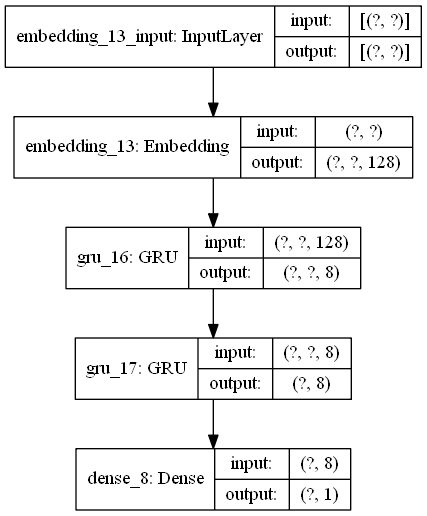

In [71]:
keras.utils.plot_model(model, show_shapes=True)

In [72]:
prep_data = preprocess(["super awful"], tf.constant([1], dtype=tf.int64))
encoded_data = encode_words(prep_data[0], prep_data[1])
print("encoded data:", encoded_data[0])
embedding_before_training = embedding_layer(encoded_data[0])
print("embedding before training:", embedding_before_training)

encoded data: tf.Tensor([[1245  260]], shape=(1, 2), dtype=int64)
embedding before training: tf.Tensor(
[[[ 0.01531693 -0.03133844  0.015521   -0.01700463  0.00096896
   -0.02320288 -0.00861937 -0.00132805 -0.00178727 -0.00169035
   -0.01717484 -0.01631671 -0.04885963  0.03622038  0.04167763
   -0.04161329 -0.03608795 -0.01152229 -0.01904765 -0.01841038
   -0.03060521 -0.00949451 -0.02437941  0.04794916  0.03086697
    0.02865903  0.01352463 -0.03077034 -0.00748695 -0.01087039
    0.01309152  0.04144322 -0.0372844  -0.04865227  0.02491566
    0.02511055  0.0038986  -0.00510634 -0.04952338  0.03071019
   -0.03366331 -0.01286105 -0.03052566 -0.00703359  0.03078934
    0.02375952 -0.02347007  0.04613004  0.0394457  -0.03204645
    0.01777646 -0.03663268 -0.04616916  0.00490768 -0.03096199
   -0.02064245 -0.02999268  0.00900977 -0.0222227   0.02175358
   -0.03532603 -0.01487968 -0.02326497 -0.00632322  0.03946371
   -0.00182173  0.01408826  0.03590579 -0.0112283  -0.0149244
    0.04237665 

In [73]:
history = model.fit(train_set, epochs=5, validation_data=test_set)

Epoch 1/5


    168/Unknown - 8s 8s/step - loss: 0.7046 - accuracy: 0.40 - 8s 4s/step - loss: 0.6979 - accuracy: 0.43 - 8s 3s/step - loss: 0.6979 - accuracy: 0.45 - 8s 2s/step - loss: 0.6954 - accuracy: 0.47 - 9s 2s/step - loss: 0.6968 - accuracy: 0.48 - 9s 1s/step - loss: 0.6954 - accuracy: 0.48 - 9s 1s/step - loss: 0.6947 - accuracy: 0.49 - 9s 1s/step - loss: 0.6946 - accuracy: 0.50 - 9s 1s/step - loss: 0.6938 - accuracy: 0.51 - 9s 923ms/step - loss: 0.6933 - accuracy: 0.518 - 9s 853ms/step - loss: 0.6938 - accuracy: 0.511 - 10s 795ms/step - loss: 0.6931 - accuracy: 0.51 - 10s 745ms/step - loss: 0.6931 - accuracy: 0.50 - 10s 703ms/step - loss: 0.6935 - accuracy: 0.51 - 10s 665ms/step - loss: 0.6934 - accuracy: 0.51 - 10s 633ms/step - loss: 0.6929 - accuracy: 0.51 - 10s 604ms/step - loss: 0.6929 - accuracy: 0.52 - 10s 580ms/step - loss: 0.6930 - accuracy: 0.51 - 11s 558ms/step - loss: 0.6935 - accuracy: 0.50 - 11s 538ms/step - loss: 0.6944 - accuracy: 0.50 - 11s 519ms/step - loss: 0.6946 - accura

782/782 [==============================]: 0.6929 - accuracy: 0.512 - 108s 161ms/step - loss: 0.6929 - accuracy: 0.512 - 108s 161ms/step - loss: 0.6929 - accuracy: 0.512 - 108s 161ms/step - loss: 0.6929 - accuracy: 0.512 - 108s 161ms/step - loss: 0.6928 - accuracy: 0.512 - 109s 161ms/step - loss: 0.6928 - accuracy: 0.512 - 109s 161ms/step - loss: 0.6928 - accuracy: 0.512 - 109s 161ms/step - loss: 0.6928 - accuracy: 0.512 - 109s 161ms/step - loss: 0.6928 - accuracy: 0.512 - 109s 161ms/step - loss: 0.6928 - accuracy: 0.512 - 109s 161ms/step - loss: 0.6927 - accuracy: 0.512 - 109s 161ms/step - loss: 0.6927 - accuracy: 0.512 - 110s 161ms/step - loss: 0.6927 - accuracy: 0.512 - 110s 161ms/step - loss: 0.6927 - accuracy: 0.512 - 110s 161ms/step - loss: 0.6926 - accuracy: 0.512 - 110s 161ms/step - loss: 0.6926 - accuracy: 0.512 - 110s 161ms/step - loss: 0.6926 - accuracy: 0.512 - 110s 161ms/step - loss: 0.6926 - accuracy: 0.512 - 110s 161ms/step - loss: 0.6926 - accuracy: 0.512 - 111s 161ms/st

186/782 [======>.......................] - ETA: 3:40 - loss: 0.6750 - accuracy: 0.50 - ETA: 2:41 - loss: 0.6647 - accuracy: 0.59 - ETA: 2:27 - loss: 0.6553 - accuracy: 0.58 - ETA: 2:23 - loss: 0.6412 - accuracy: 0.58 - ETA: 2:19 - loss: 0.6424 - accuracy: 0.58 - ETA: 2:15 - loss: 0.6466 - accuracy: 0.59 - ETA: 2:11 - loss: 0.6396 - accuracy: 0.60 - ETA: 2:12 - loss: 0.6339 - accuracy: 0.61 - ETA: 2:12 - loss: 0.6376 - accuracy: 0.60 - ETA: 2:12 - loss: 0.6359 - accuracy: 0.61 - ETA: 2:10 - loss: 0.6375 - accuracy: 0.62 - ETA: 2:09 - loss: 0.6393 - accuracy: 0.63 - ETA: 2:09 - loss: 0.6366 - accuracy: 0.63 - ETA: 2:09 - loss: 0.6393 - accuracy: 0.63 - ETA: 2:08 - loss: 0.6429 - accuracy: 0.63 - ETA: 2:08 - loss: 0.6452 - accuracy: 0.62 - ETA: 2:08 - loss: 0.6477 - accuracy: 0.62 - ETA: 2:08 - loss: 0.6478 - accuracy: 0.62 - ETA: 2:09 - loss: 0.6416 - accuracy: 0.64 - ETA: 2:08 - loss: 0.6478 - accuracy: 0.63 - ETA: 2:08 - loss: 0.6459 - accuracy: 0.63 - ETA: 2:07 - loss: 0.6466 - accura

782/782 [==============================] - ETA: 5s - loss: 0.5542 - accuracy: 0.72 - ETA: 5s - loss: 0.5540 - accuracy: 0.72 - ETA: 5s - loss: 0.5538 - accuracy: 0.72 - ETA: 5s - loss: 0.5537 - accuracy: 0.72 - ETA: 4s - loss: 0.5532 - accuracy: 0.72 - ETA: 4s - loss: 0.5529 - accuracy: 0.72 - ETA: 4s - loss: 0.5528 - accuracy: 0.72 - ETA: 4s - loss: 0.5527 - accuracy: 0.72 - ETA: 4s - loss: 0.5529 - accuracy: 0.72 - ETA: 4s - loss: 0.5527 - accuracy: 0.72 - ETA: 4s - loss: 0.5525 - accuracy: 0.72 - ETA: 3s - loss: 0.5526 - accuracy: 0.72 - ETA: 3s - loss: 0.5524 - accuracy: 0.72 - ETA: 3s - loss: 0.5525 - accuracy: 0.72 - ETA: 3s - loss: 0.5524 - accuracy: 0.72 - ETA: 3s - loss: 0.5523 - accuracy: 0.72 - ETA: 3s - loss: 0.5522 - accuracy: 0.72 - ETA: 2s - loss: 0.5521 - accuracy: 0.72 - ETA: 2s - loss: 0.5520 - accuracy: 0.72 - ETA: 2s - loss: 0.5519 - accuracy: 0.72 - ETA: 2s - loss: 0.5518 - accuracy: 0.73 - ETA: 2s - loss: 0.5514 - accuracy: 0.73 - ETA: 2s - loss: 0.5515 - accuracy

186/782 [======>.......................] - ETA: 2:42 - loss: 0.5705 - accuracy: 0.68 - ETA: 2:22 - loss: 0.4705 - accuracy: 0.78 - ETA: 2:05 - loss: 0.4421 - accuracy: 0.81 - ETA: 2:03 - loss: 0.4294 - accuracy: 0.82 - ETA: 1:59 - loss: 0.4238 - accuracy: 0.82 - ETA: 1:56 - loss: 0.4081 - accuracy: 0.81 - ETA: 1:55 - loss: 0.4163 - accuracy: 0.80 - ETA: 1:53 - loss: 0.4147 - accuracy: 0.80 - ETA: 1:50 - loss: 0.4241 - accuracy: 0.79 - ETA: 1:49 - loss: 0.4282 - accuracy: 0.79 - ETA: 1:49 - loss: 0.4354 - accuracy: 0.79 - ETA: 1:48 - loss: 0.4436 - accuracy: 0.78 - ETA: 1:47 - loss: 0.4532 - accuracy: 0.78 - ETA: 1:46 - loss: 0.4485 - accuracy: 0.78 - ETA: 1:46 - loss: 0.4571 - accuracy: 0.77 - ETA: 1:46 - loss: 0.4654 - accuracy: 0.77 - ETA: 1:46 - loss: 0.4626 - accuracy: 0.78 - ETA: 1:46 - loss: 0.4655 - accuracy: 0.78 - ETA: 1:46 - loss: 0.4568 - accuracy: 0.78 - ETA: 1:46 - loss: 0.4634 - accuracy: 0.78 - ETA: 1:46 - loss: 0.4592 - accuracy: 0.78 - ETA: 1:46 - loss: 0.4585 - accura

782/782 [==============================] - ETA: 5s - loss: 0.4205 - accuracy: 0.82 - ETA: 5s - loss: 0.4203 - accuracy: 0.82 - ETA: 4s - loss: 0.4201 - accuracy: 0.82 - ETA: 4s - loss: 0.4201 - accuracy: 0.82 - ETA: 4s - loss: 0.4197 - accuracy: 0.82 - ETA: 4s - loss: 0.4196 - accuracy: 0.82 - ETA: 4s - loss: 0.4196 - accuracy: 0.82 - ETA: 4s - loss: 0.4195 - accuracy: 0.82 - ETA: 4s - loss: 0.4196 - accuracy: 0.82 - ETA: 3s - loss: 0.4196 - accuracy: 0.82 - ETA: 3s - loss: 0.4196 - accuracy: 0.82 - ETA: 3s - loss: 0.4199 - accuracy: 0.82 - ETA: 3s - loss: 0.4197 - accuracy: 0.82 - ETA: 3s - loss: 0.4199 - accuracy: 0.82 - ETA: 3s - loss: 0.4198 - accuracy: 0.82 - ETA: 3s - loss: 0.4196 - accuracy: 0.82 - ETA: 2s - loss: 0.4195 - accuracy: 0.82 - ETA: 2s - loss: 0.4192 - accuracy: 0.82 - ETA: 2s - loss: 0.4191 - accuracy: 0.82 - ETA: 2s - loss: 0.4193 - accuracy: 0.82 - ETA: 2s - loss: 0.4194 - accuracy: 0.82 - ETA: 2s - loss: 0.4190 - accuracy: 0.82 - ETA: 2s - loss: 0.4192 - accuracy

186/782 [======>.......................] - ETA: 3:08 - loss: 0.4975 - accuracy: 0.81 - ETA: 2:11 - loss: 0.4126 - accuracy: 0.81 - ETA: 1:57 - loss: 0.3778 - accuracy: 0.84 - ETA: 1:56 - loss: 0.3806 - accuracy: 0.83 - ETA: 1:51 - loss: 0.3723 - accuracy: 0.84 - ETA: 1:48 - loss: 0.3567 - accuracy: 0.85 - ETA: 1:48 - loss: 0.3775 - accuracy: 0.84 - ETA: 1:47 - loss: 0.3660 - accuracy: 0.85 - ETA: 1:46 - loss: 0.3598 - accuracy: 0.85 - ETA: 1:45 - loss: 0.3627 - accuracy: 0.85 - ETA: 1:46 - loss: 0.3612 - accuracy: 0.85 - ETA: 1:48 - loss: 0.3643 - accuracy: 0.84 - ETA: 1:49 - loss: 0.3642 - accuracy: 0.84 - ETA: 1:48 - loss: 0.3744 - accuracy: 0.84 - ETA: 1:48 - loss: 0.3769 - accuracy: 0.83 - ETA: 1:48 - loss: 0.3867 - accuracy: 0.83 - ETA: 1:48 - loss: 0.3894 - accuracy: 0.83 - ETA: 1:47 - loss: 0.3881 - accuracy: 0.83 - ETA: 1:47 - loss: 0.3920 - accuracy: 0.83 - ETA: 1:48 - loss: 0.3912 - accuracy: 0.83 - ETA: 1:47 - loss: 0.3836 - accuracy: 0.83 - ETA: 1:46 - loss: 0.3845 - accura

782/782 [==============================] - ETA: 5s - loss: 0.3554 - accuracy: 0.85 - ETA: 5s - loss: 0.3552 - accuracy: 0.85 - ETA: 5s - loss: 0.3551 - accuracy: 0.85 - ETA: 4s - loss: 0.3553 - accuracy: 0.85 - ETA: 4s - loss: 0.3550 - accuracy: 0.85 - ETA: 4s - loss: 0.3550 - accuracy: 0.85 - ETA: 4s - loss: 0.3550 - accuracy: 0.85 - ETA: 4s - loss: 0.3548 - accuracy: 0.85 - ETA: 4s - loss: 0.3549 - accuracy: 0.85 - ETA: 3s - loss: 0.3548 - accuracy: 0.85 - ETA: 3s - loss: 0.3550 - accuracy: 0.85 - ETA: 3s - loss: 0.3551 - accuracy: 0.85 - ETA: 3s - loss: 0.3550 - accuracy: 0.85 - ETA: 3s - loss: 0.3549 - accuracy: 0.85 - ETA: 3s - loss: 0.3549 - accuracy: 0.85 - ETA: 3s - loss: 0.3548 - accuracy: 0.85 - ETA: 2s - loss: 0.3546 - accuracy: 0.85 - ETA: 2s - loss: 0.3544 - accuracy: 0.85 - ETA: 2s - loss: 0.3543 - accuracy: 0.85 - ETA: 2s - loss: 0.3543 - accuracy: 0.85 - ETA: 2s - loss: 0.3543 - accuracy: 0.85 - ETA: 2s - loss: 0.3540 - accuracy: 0.85 - ETA: 2s - loss: 0.3543 - accuracy

186/782 [======>.......................] - ETA: 3:22 - loss: 0.4592 - accuracy: 0.78 - ETA: 2:30 - loss: 0.3155 - accuracy: 0.87 - ETA: 2:24 - loss: 0.2821 - accuracy: 0.90 - ETA: 2:19 - loss: 0.2668 - accuracy: 0.91 - ETA: 2:15 - loss: 0.2752 - accuracy: 0.91 - ETA: 2:15 - loss: 0.2774 - accuracy: 0.90 - ETA: 2:10 - loss: 0.3098 - accuracy: 0.88 - ETA: 2:09 - loss: 0.2939 - accuracy: 0.89 - ETA: 2:08 - loss: 0.2912 - accuracy: 0.89 - ETA: 2:05 - loss: 0.2915 - accuracy: 0.89 - ETA: 2:05 - loss: 0.2939 - accuracy: 0.89 - ETA: 2:06 - loss: 0.3081 - accuracy: 0.88 - ETA: 2:05 - loss: 0.3147 - accuracy: 0.87 - ETA: 2:05 - loss: 0.3177 - accuracy: 0.87 - ETA: 2:03 - loss: 0.3162 - accuracy: 0.87 - ETA: 2:05 - loss: 0.3223 - accuracy: 0.86 - ETA: 2:04 - loss: 0.3319 - accuracy: 0.86 - ETA: 2:03 - loss: 0.3382 - accuracy: 0.85 - ETA: 2:03 - loss: 0.3367 - accuracy: 0.85 - ETA: 2:03 - loss: 0.3326 - accuracy: 0.86 - ETA: 2:02 - loss: 0.3336 - accuracy: 0.86 - ETA: 2:01 - loss: 0.3350 - accura

782/782 [==============================] - ETA: 5s - loss: 0.3113 - accuracy: 0.88 - ETA: 5s - loss: 0.3112 - accuracy: 0.88 - ETA: 5s - loss: 0.3112 - accuracy: 0.88 - ETA: 4s - loss: 0.3113 - accuracy: 0.88 - ETA: 4s - loss: 0.3110 - accuracy: 0.88 - ETA: 4s - loss: 0.3109 - accuracy: 0.88 - ETA: 4s - loss: 0.3110 - accuracy: 0.88 - ETA: 4s - loss: 0.3108 - accuracy: 0.88 - ETA: 4s - loss: 0.3109 - accuracy: 0.88 - ETA: 3s - loss: 0.3108 - accuracy: 0.88 - ETA: 3s - loss: 0.3109 - accuracy: 0.88 - ETA: 3s - loss: 0.3110 - accuracy: 0.88 - ETA: 3s - loss: 0.3109 - accuracy: 0.88 - ETA: 3s - loss: 0.3110 - accuracy: 0.88 - ETA: 3s - loss: 0.3110 - accuracy: 0.88 - ETA: 3s - loss: 0.3108 - accuracy: 0.88 - ETA: 2s - loss: 0.3105 - accuracy: 0.88 - ETA: 2s - loss: 0.3104 - accuracy: 0.88 - ETA: 2s - loss: 0.3103 - accuracy: 0.88 - ETA: 2s - loss: 0.3102 - accuracy: 0.88 - ETA: 2s - loss: 0.3102 - accuracy: 0.88 - ETA: 2s - loss: 0.3100 - accuracy: 0.88 - ETA: 2s - loss: 0.3102 - accuracy

In [74]:
embedding_after_training = embedding_layer(encoded_data[0])
print("embedding after training:", embedding_after_training)

embedding after training: tf.Tensor(
[[[ 5.12222834e-02 -3.54614332e-02 -6.99301157e-03  6.55061305e-02
    1.17725186e-01  4.73873913e-02  1.48138657e-04  9.63756070e-02
   -1.57193337e-02  1.61605373e-01 -6.38569891e-02 -9.18764845e-02
   -1.18823193e-01  5.01024313e-02  1.77622605e-02  1.95001848e-02
   -1.89326815e-02  4.46703508e-02  9.41374246e-03 -3.32632102e-02
    8.09935704e-02  1.41982045e-02 -5.47248460e-02  1.27258599e-01
    1.08736299e-01 -6.57397956e-02  1.42630246e-02 -2.14258954e-02
   -8.90305489e-02 -2.25713886e-02  1.06495850e-01  2.53729429e-02
   -4.28477302e-03  2.98489016e-02  1.09131299e-01 -7.27060884e-02
    7.68182427e-02  5.08777983e-02 -1.64062995e-03 -1.16279051e-02
    1.44708082e-02  6.27030134e-02 -1.11893430e-01 -4.32979204e-02
   -5.32144494e-03 -2.45198775e-02  1.22920543e-01  7.26438984e-02
   -7.14122802e-02  3.80349867e-02  1.59144953e-01 -6.17501624e-02
   -6.79510832e-02  1.23920768e-01  3.73990536e-02  9.61409584e-02
   -5.69881722e-02  3.659

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


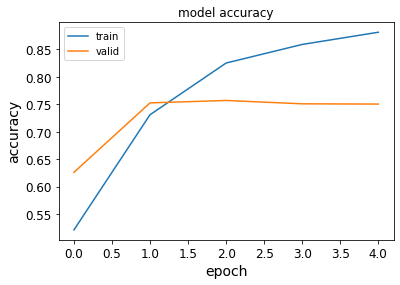

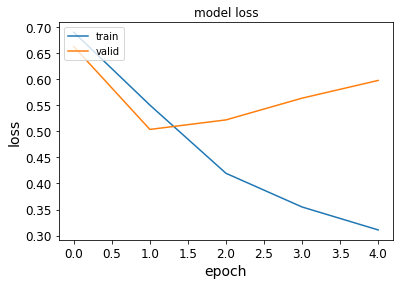

In [75]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

Automatic translation

In [17]:

vocab_size = 101
embed_size = 10


In [1]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths, training=True)
Y_proba = tf.nn.softmax(final_outputs.rnn_output, name="softmax")

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

model.summary()

NameError: name 'keras' is not defined

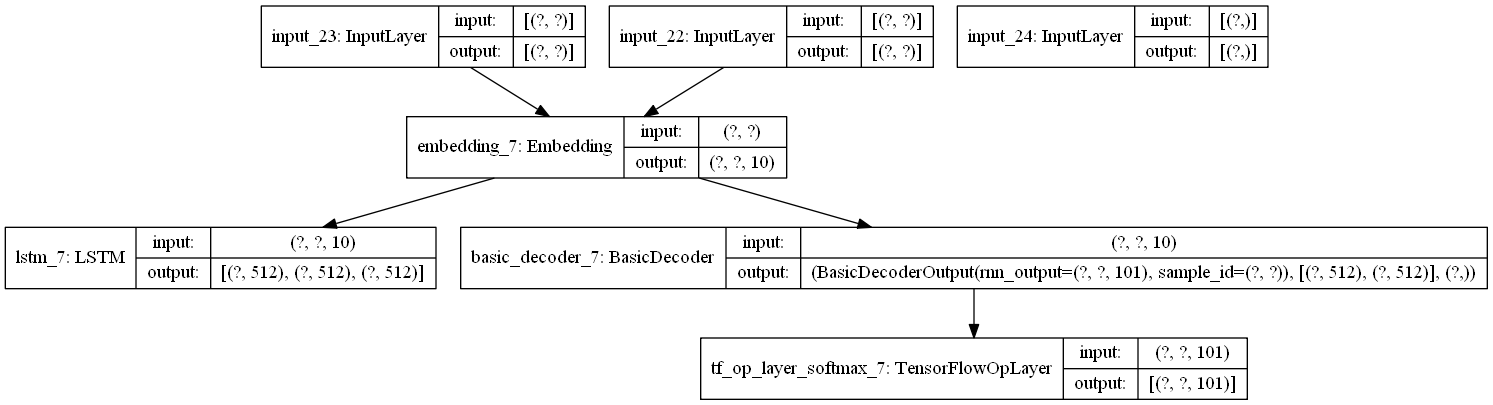

In [19]:
keras.utils.plot_model(model, show_shapes=True)

In [17]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 4s 138ms/step - loss: 4.6051
Epoch 2/2
32/32 [==============================] - 4s 138ms/step - loss: 4.6037


Bidirectional Recurrent Layers¶

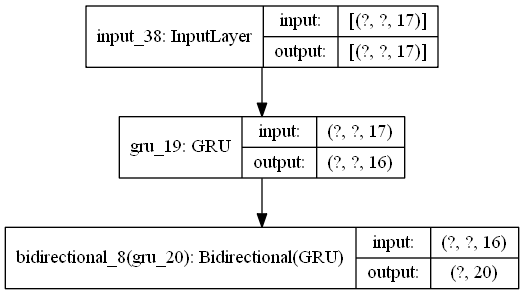

In [37]:
model = keras.models.Sequential([
    keras.layers.Input(shape=[None, 17]),
    keras.layers.GRU(16, return_sequences=True),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=False))
])
keras.utils.plot_model(model, show_shapes=True)

Positional encoding

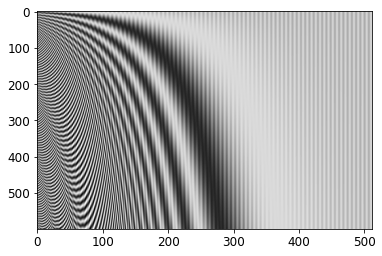

In [71]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]
    
pos_encoder = PositionalEncoding(600, 512)
arr1 = pos_encoder(np.zeros((1, 600, 512),dtype=np.float32))
plt.imshow(arr1[0].numpy(), cmap="gray", aspect="auto")

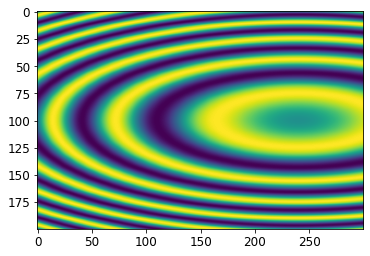

In [89]:
xx,yy = np.meshgrid(np.linspace(-4,1,300), np.linspace(-5,5,200))
z = np.sin(xx**2 + yy **2)
plt.imshow(z)

#### -------------- Excercises

###### 8) Reber grammar

In [506]:
default_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [("S", 2), ("X", 4)],
    [("T", 3), ("V", 5)],
    [("S", 6), ("X", 3)],
    [("P", 4), ("V", 6)],
    [("E", None)]
]

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)],
]

def reber_grammar_generator(grammar):
    result = []

    curr_state_idx = 0
    while curr_state_idx is not None:
        path_id = np.random.randint(len(grammar[curr_state_idx]))
        node, new_state_idx = grammar[curr_state_idx][path_id]
        if(isinstance(node, list)):
            node = reber_grammar_generator(node)
        result.append(node)
        curr_state_idx = new_state_idx
    
    return "".join(result)

def bad_grammar_generator(grammar):
    POSSIBLE_CHARS = "BEPSTVX"
#     POSSIBLE_CHARS = "12345678"
    good_grammar = reber_grammar_generator(grammar)
    rand_pos = np.random.randint(len(good_grammar))
    good_char = good_grammar[rand_pos]
    bad_char = np.random.choice(sorted(set(POSSIBLE_CHARS) - set(good_char)))
#     print(good_grammar)
#     print("->".join([good_char, bad_char]))
    
    return good_grammar[:rand_pos] + bad_char + good_grammar[rand_pos + 1:]

print(bad_grammar_generator(default_reber_grammar))

BTXXTPPSE


In [606]:
def encode_string(string):
    return [POSSIBLE_CHARS.index(_) for _ in string]

In [719]:
def get_N_samples_of_good_grammar(num, grammar):
    return [encode_string(reber_grammar_generator(grammar)) for _ in range(num)], [1. for _ in range(num)]
def get_N_samples_of_bad_grammar(num, grammar):
    return [encode_string(bad_grammar_generator(grammar)) for _ in range(num)], [0. for _ in range(num)]

def get_dataset(num):
    x_good_grammar, y_good_grammar = get_N_samples_of_good_grammar(num // 2, embedded_reber_grammar)
    x_bad_grammar, y_bad_grammar = get_N_samples_of_bad_grammar(num // 2, embedded_reber_grammar)

    __X = tf.ragged.constant(x_good_grammar + x_bad_grammar)
    __y = tf.constant(y_good_grammar + y_bad_grammar)

    return tf.data.Dataset.from_tensor_slices((__X, __y)).shuffle(10000).batch(16)



In [720]:
train_ds = get_dataset(10000)
valid_ds = get_dataset(2000)


In [700]:
embed_size = 5

model = keras.models.Sequential([
#     keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    keras.layers.Embedding(input_dim = len(POSSIBLE_CHARS)+1, output_dim = embed_size, input_shape=[None]),
#     keras.layers.GRU(30, return_sequences=True),
    keras.layers.GRU(30),
    keras.layers.Dense(1, activation="sigmoid"),
])

model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, None, 5)           40        
_________________________________________________________________
gru_57 (GRU)                 (None, 30)                3330      
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 31        
Total params: 3,401
Trainable params: 3,401
Non-trainable params: 0
_________________________________________________________________


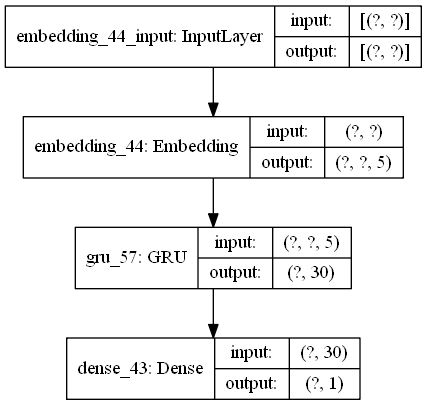

In [701]:
keras.utils.plot_model(model, show_shapes=True)

In [721]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.95, nesterov=True)
model.reset_states()
model.compile(loss = "binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_ds, epochs=20, validation_data=valid_ds)
# history = model.fit(train_ds_x1, train_ds_y1, epochs=20)

Epoch 1/20


C:\Users\ikuchin\AppData\Local\Continuum\miniconda3\envs\tf22\lib\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


625/625 [==============================] - 10s 16ms/step - loss: 0.5007 - accuracy: 0.7823 - val_loss: 0.1152 - val_accuracy: 0.9820
Epoch 2/20
625/625 [==============================] - 10s 16ms/step - loss: 0.1183 - accuracy: 0.9696 - val_loss: 0.0741 - val_accuracy: 0.9835
Epoch 3/20
625/625 [==============================] - 10s 16ms/step - loss: 0.0665 - accuracy: 0.9859 - val_loss: 0.0609 - val_accuracy: 0.9860
Epoch 4/20
625/625 [==============================] - 9s 15ms/step - loss: 0.0532 - accuracy: 0.9888 - val_loss: 0.0605 - val_accuracy: 0.9855
Epoch 5/20
625/625 [==============================] - 9s 15ms/step - loss: 0.0459 - accuracy: 0.9884 - val_loss: 0.0204 - val_accuracy: 0.9920
Epoch 6/20
625/625 [==============================] - 9s 15ms/step - loss: 0.0106 - accuracy: 0.9985 - val_loss: 0.0395 - val_accuracy: 0.9910
Epoch 7/20
625/625 [==============================] - 9s 15ms/step - loss: 0.0418 - accuracy: 0.9887 - val_loss: 0.0255 - val_accuracy: 0.9930
Epoch 8

KeyboardInterrupt: 

In [736]:
true_predictions =tf.ragged.constant([
    encode_string("BTSXXVPSE"),
    encode_string("BTSSSSSSSSSSSSSSSSSSSSSSSSSSSSSXXVPSE"),
    encode_string("BTSXXVPXVPXVPXVPXVPXVPXVPXVPXVPXVPXVPXVPXVPXVPXVPXVPXVPXVPXVPXVPXVPXVPXVPXVPXVPXTTTTTTTTTTTVPSE"),
    encode_string("BTSXXVPSE"),
    encode_string("BTSXXVPSE"),
    encode_string("BPBTSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSXXTTVPXVPXTTTTTTTTTTTTVVEPE"),
])
false_predictions =tf.ragged.constant([
    encode_string("BTSXXVPXTVPXTVTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTVVE"),
    encode_string("BSXXVPSE"),
    encode_string("BPSPSE"),
    encode_string("BPTPSE"),
    encode_string("BPXVE"),
    encode_string("BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE"),
])
print(model.predict(true_predictions))
print(model.predict(false_predictions))

[[1.06215084e-04]
 [2.55938823e-04]
 [7.93335275e-05]
 [1.06215084e-04]
 [1.06215084e-04]
 [9.54441667e-01]]
[[3.0016108e-05]
 [8.0932733e-07]
 [1.3775079e-08]
 [1.9931496e-08]
 [4.4371749e-04]
 [5.5476397e-02]]


In [697]:
model.evaluate(valid_ds)

125/125 [==============================] - 0s 2ms/step - loss: 5.8096e-04 - accuracy: 1.0000


[0.0005809626309201121, 1.0]

Date Encoder-Decoder 

In [707]:
from datetime import date
date(1980,4, 5).isoformat()

'1980-04-05'

In [718]:
XX = tf.ragged.constant([[1,2,3],[33,44]])
(XX).to_tensor()

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 1,  2,  3],
       [33, 44,  0]])>

#### Encoder–Decoder model that can convert a date string from one format to another